# Lab 08 : Heat Flow

## Objectives

In this lab we will solve a system of linear equations to study heat flow in a rod and produce nice, color heat maps of the results using `imshow`.

Much of the preparation for this lab was discussed in the prelab.  **You must understand and complete PreLab 08 to proceed!**  In fact, once you have completed the prelab we can just apply those results to a couple of initial conditions.

## Initialization

As always, initialize your environment now by loading all modules required and setting up the plotting environment.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.interpolate as interp
import scipy.special as sf
import scipy.integrate as integ
import scipy.linalg as la

## Heat Flow

The prelab contains a more thorough discussion of how we will solve for the heat flow through a rod.  Here we summarize the important points.

The temperature at position $x$ and time $t$, $T(t,x)$, satisfies the partial differential equation
$$ \frac{\partial T}{\partial t} = \frac{\partial^2 T}{\partial x^2}. $$
Using the *Crank-Nicolson* method it can be shown that this partial differential equation becomes the **system of linear equations**
$$
-r T(t_{j+1},x_{i-1}) + (1+2r) T(t_{j+1},x_i) - r T(t_{j+1},x_{i+1}) = r T(t_j,x_{i-1}) + (1-2r) T(t_j,x_i) +r T(t_j,x_{i+1}),
$$
where
$$ r\equiv \frac{\Delta t}{2(\Delta x)^2},$$
and $\Delta t$ and $\Delta x$ are the time and space step sizes.  In the prelab we saw that this can be written in the form
$$ \mathsf{A}\vec T_{j+1} = \mathsf{B} \vec T_j \equiv \vec \tau_j, $$
where we know how to construct $\mathsf{A}$ and $\vec\tau_j$.  Further, we discussed solving this system using `scipy.linalg.solve_banded`.  We will apply this now.

(*Note:* As mentioned in the prelab, you can use `scipy.linalg.solveh_banded` instead of `scipy.linalg.solve_banded` if so inclined.)

Copy the useful results from the prelab.  In particular, your functions for calculating $\vec\tau_j$ and the coefficient matrix should be included here.

In [4]:
def tau(T, r):
    tau= np.zeros_like(T)
    tau[0]= (1-2*r)*T[0] + r*T[1]
    tau[1:-1]= r*T[0:-2] + (1-2*r)*T[1:-1] + r*T[2:]
    tau[-1]= r*T[-2] + (1-2*r)*T[-1]
    return tau

def coefficient_matrix(N, r):
    A_band= np.zeros((3, N))
    A_band[1, ::]= 1+2*r
    A_band[0,1:]= -r
    A_band[2,:-1]= -r
    return A_band

## Test Case

As has been stated a few times, whenever we solve a numerical problem we should first apply our technique to a problem with a known solution.  It is easy to make simple mistakes and solving a known problem can catch many (but not necessarily all) such mistakes.

For our test problem we will solve for the temperature along a rod of length $L=1$ discretized by splitting it into $1000$ segments ($N_x=1001$ points).  For the initial temperature profile we will let $T(0,x)=\sin(\pi x)$.  To evolve the system choose $\Delta t=10^{-4}$ and evolve for $N_t=N_x$ steps.  Evolve the system by solving the linear system of equations at each time step.  (In this case you *must* use a loop to step through time.)  Store your results in a two dimensional array, `T[j,i]`, so that each *row* of the array is the temperature along the rod at a particular time.

For these initial conditions the known solution is $T(t,x) = \mathrm{e}^{-\pi^2 t} \sin(\pi x)$.  We will use this to test our numerical solution.

Solve for the heat flow in the rod as a function of time, $T(t,x)$, using the method described above.  Provide the code for doing this below.  You should also test your solution!  One way to do this is to produce quick plots at various times of your result and the known solution.  You may include these plots in your notebook if you prefer, regardless, you should find good agreement (at least at the level of plots) between your solution and the known one.

In [51]:
deltt= 10**-4
deltx= 10**-4
r= deltt/ (2*deltx**2)
N= np.arange(0, 1001, 1)

def T(x,t):
    return np.exp(-t*np.pi**2)*np.sin(np.pi*x)

A= coefficient_matrix(1001,r)

x= deltx*N

T0= T(x, 0)

T_list= np.zeros([N[-1],len(T0)])
tau_list= np.zeros([N[-1],len(T0)])

T_list[0]= T0
tau_list[0]= tau(T0, r)


for i in range(1, len(N)-1):
    T_list[i]= la.solve_banded((1,1), A, tau_list[i-1])
    tau_list[i]= tau(T_list[i], r)
    
T_list   



array([[ 0.00000000e+00,  3.14159260e-04,  6.28318489e-04, ...,
         3.08419367e-01,  3.08718196e-01,  3.09016994e-01],
       [ 6.19177541e-04,  9.24319657e-04,  1.22958384e-03, ...,
        -2.84526822e-01, -2.92668985e-01, -3.00931394e-01],
       [ 7.98410650e-06,  3.29881399e-04,  6.51537741e-04, ...,
         2.83252759e-01,  2.91701605e-01,  3.00387572e-01],
       ...,
       [ 1.45572947e-04,  5.40682606e-05,  8.45403714e-06, ...,
        -8.32369843e-03, -5.32346723e-02, -1.43328601e-01],
       [-1.45512525e-04, -5.40056341e-05, -8.41082058e-06, ...,
         8.28114816e-03,  5.31730112e-02,  1.43269110e-01],
       [ 1.45452154e-04,  5.39430851e-05,  8.36768332e-06, ...,
        -8.23867596e-03, -5.31114266e-02, -1.43209670e-01]])

Produce a nice figure of your results showing the temperature along the rod at the times, $t=0$, $0.025$, $0.05$, $0.075$, and $0.1$.

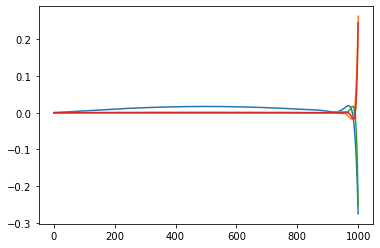

In [55]:
plt.plot(T_list[25])

plt.plot(T_list[50])
plt.plot(T_list[75])
plt.plot(T_list[100])

The above plot is nice, but it is even nicer to see the actual two dimensional heat flow.  We can do this using `imshow`.  Unfortunately `imshow` has some behavior we need to work around.  It knows nothing about what the $x$ and $y$ axes represent so just uses index values.  It also starts with $(0,0)$ in the upper left corner whereas for us it would make more sense to put it in the lower left corner (reverse the $y$-axis).  We can fix these issues and make the plot much nicer by doing a few things.  Here I will assume we use the usual variables `fig` and `ax` when we create a figure.  Modify the function calls given below as need be.

1. As noted, our $y$-axis represents time and it makes more sense to have time increasing as we move upward.  This behavior can easily be changed by switching the order of the limits on the $y$-axis.  When you first use `imshow` if you check the limits using `ax.get_ylim()` what do you see?  How do we change the limits along the $y$-axis?  Alternatively the order of the input array can be reversed (at least for the $y$-axis).  This is less elegant, but does work.
1. The use of index numbers for the axis tick labels is not very informative.  We do have full control over ticks and their labels, but modifying them can become involved if we want a generic way of manipulating them.  For our purposes if we just want to change the tick labels we can use `ax.set_xticklabels` and `ax.set_yticklabels`.  Even with these there are some details to work out.  Though it is much nicer to do so, it is **not required to fix the tick labels**.  You may leave them as index values if you prefer.
1. We have produced a nice color image with `imshow`, but what do the colors mean?  We must add a color bar to the figure to show what each color represents.  To do this note that `imshow` returns an object when it is called.  This object knows all about what was plotted, in particular what color map was used and the mapping between colors and numeric values.  We will need to store this object so suppose we call it `img`.  With this object we can construct a color bar using `cb = fig.colorbar(img)`.  Notice that this stores the returned color bar object in the variable `cb`.  We now have a nice color bar but what does *it* represent?  We can use `cb.set_label` to put a label on it.
1. Finally, all the other rules we have used when producing nice figures still apply and must be followed.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Fixed End Temperature Case

As another example, let us consider the case where the rod starts at a constant temperature but with the ends held at fixed temperatures.  We wish to see how the heat propagates from the ends of the rod in this case.

As a specific example we will consider $T(0,x)=100$ except at the end points where $T(0,0)=50$ and $T(0,1)=200$.

To keep these end points fixed we need to do a few things.
1. Go back to the matrix $\mathsf{A}$ from the prelab.  We modify it by setting the first and last rows of this matrix to zero, then setting the diagonal elements to one, that is $A_{0,0}=A_{N-1,N-1}=1$.  This will lead to small changes in how we construct the banded matrix `ab`.
1. We need to make similar changes on the right hand side of the equation.  The easiest way to do this is to reuse what we did for the test case and then change the end points by hand.  This means, calculate $\vec\tau_j$ as we did above, but then replace the first element in this vector with $T(0,0)$ and the last element with $T(0,1)$.

Finally, to obtain a numerically stable solution let $N_x=101$, $N_t=1001$, and $\Delta t=2\times 10^{-4}$.

Solve for the heat flow in the rod as function of time, $T(t,x)$, using the method described above.  Provide the code for doing this below.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Produce a nice figure of your results showing the temperature along the rod at the times, $t=0$, $0.025$, $0.05$, $0.075$, and $0.2$.  This figure should make sense.  In particular, after a long time what do you expect the temperature profile to look like?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

We again want to produce a heat flow image using `imshow`.  If we do this we find the resulting image is a thin rectangle since $N_x\ne N_t$.  To get a square image we can use the keyword argument `aspect="auto"` to `imshow` which will automatically stretch the rectangle into a square.  Otherwise the procedure is the same as that followed in the test case above.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Member Participation

See Lab00 for instructions on turning in labs.  We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who partcipated in this lab.  Again, see Lab00 for more details.  It is expected that you have read and understood those details.